In [34]:
#!pip install tensorflow_text

In [35]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [36]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/nzlul03/BERT_e-mail_classification/main/spam.csv')

In [37]:
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [38]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [39]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [40]:
747/4825

0.15481865284974095

15% spam emails, 85% ham emails: This indicates class imbalance

In [41]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [42]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

## Downsample the ham

In [43]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [44]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [45]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [46]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
1190,ham,In that case I guess I'll see you at campus lodge,0
414,ham,Bring home some Wendy =D,0
1573,spam,Ur cash-balance is currently 500 pounds - to m...,1
5228,spam,PRIVATE! Your 2003 Account Statement for <fone...,1
5079,spam,Do you want a New Nokia 3510i colour phone Del...,1


## Train Test Split

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],
                                                    df_balanced['spam'],
                                                    stratify = df_balanced['spam'])

Now lets import BERT model and get the embedding vectors for few sample statements.

In [48]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

just take some example to get the output

In [49]:
def get_sentence_embedding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']  

In [50]:
get_sentence_embedding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)  

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351724, -0.51327276, -0.88845724, ..., -0.74748844,
        -0.7531474 ,  0.91964495],
       [-0.87208337, -0.5054394 , -0.94446665, ..., -0.85847497,
        -0.71745324,  0.8808295 ]], dtype=float32)>

Get embedding vectors for few sample words, and compare them using cosine similarity

In [51]:
e = get_sentence_embedding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [52]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

## Build Models

Functional Model

In [53]:
# Bert layers
text_input = tf.keras.layers.Input(shape = (),
                                   dtype = tf.string,
                                   name = 'text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name = 'dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'output')(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [54]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [55]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = METRICS)

## Train the Model

In [56]:
model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
35/35 [==============================] - 22s 359ms/step - loss: 0.6488 - accuracy: 0.6214 - precision: 0.6227 - recall: 0.6161
Epoch 2/10
35/35 [==============================] - 13s 382ms/step - loss: 0.5365 - accuracy: 0.7839 - precision: 0.7760 - recall: 0.7982
Epoch 3/10
35/35 [==============================] - 14s 392ms/step - loss: 0.4543 - accuracy: 0.8366 - precision: 0.8256 - recall: 0.8536
Epoch 4/10
35/35 [==============================] - 13s 371ms/step - loss: 0.4174 - accuracy: 0.8509 - precision: 0.8270 - recall: 0.8875
Epoch 5/10
35/35 [==============================] - 12s 346ms/step - loss: 0.3851 - accuracy: 0.8687 - precision: 0.8566 - recall: 0.8857
Epoch 6/10
35/35 [==============================] - 12s 352ms/step - loss: 0.3502 - accuracy: 0.8795 - precision: 0.8620 - recall: 0.9036
Epoch 7/10
35/35 [==============================] - 12s 350ms/step - loss: 0.3366 - accuracy: 0.8830 - precision: 0.8705 - recall: 0.9000
Epoch 8/10
35/35 [================

In [57]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 5s 342ms/step - loss: 0.2799 - accuracy: 0.8930 - precision: 0.8693 - recall: 0.9251


[0.2799491882324219, 0.893048107624054, 0.8693467378616333, 0.9251337051391602]

In [58]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 5s 344ms/step


In [59]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,

In [60]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[161,  26],
       [ 14, 173]])

Text(33.0, 0.5, 'Truth')

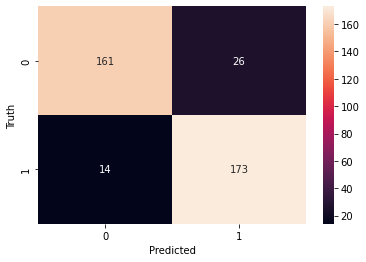

In [61]:
# Visualize the confusion matrix

from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Truth')

In [62]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       187
           1       0.87      0.93      0.90       187

    accuracy                           0.89       374
   macro avg       0.89      0.89      0.89       374
weighted avg       0.89      0.89      0.89       374



In [63]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       187
           1       0.87      0.93      0.90       187

    accuracy                           0.89       374
   macro avg       0.89      0.89      0.89       374
weighted avg       0.89      0.89      0.89       374



## Inference

In [64]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 1s/step


array([[0.7067439 ],
       [0.8347627 ],
       [0.7901833 ],
       [0.2274571 ],
       [0.13725005]], dtype=float32)

## References

https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/47_BERT_text_classification/BERT_email_classification-handle-imbalance.ipynb